In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import json
import re
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lib import utils
from lib import firth
import multiprocessing as mp
from tqdm import tqdm


folder_path = "jatos_results"
metadata_path = 'jatos_results\metadata.json'
out_path_choice = 'choice_data.csv'
out_path_rabbit = 'rabbit_data.csv'

plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['font.size'] = 12
plt.rcParams['text.usetex'] = True

In [3]:
with open(metadata_path, 'r') as f:
    meta_data = json.load(f)

meta_keys = ['id','duration','studyState','workerId']
meta_workers = meta_data['data'][0]['studyResults']

df_meta = []

for i in range(len(meta_workers)):

    row = {key:meta_workers[i][key] for key in meta_keys}
    try:
        row['prolific'] = meta_workers[i]['urlQueryParameters']['PROLIFIC_PID']
        df_meta += [row]
    except:
        print(row)
    
df_meta = pd.DataFrame(df_meta)
df_meta = df_meta.rename(columns={'id':'study_result_id','studyState':'state','workerId':'worker_id'})

def duration_to_seconds(duration_str):
    time_duration = datetime.strptime(duration_str, '%H:%M:%S')
    total_seconds = time_duration.hour * 3600 + time_duration.minute * 60 + time_duration.second
    return total_seconds

df_meta['duration'] = df_meta['duration'].apply(duration_to_seconds)


In [4]:
df_choice_pure = []
df_choice_memory = []
df_rabbit_pure = []
df_rabbit_memory = []
df_group = []


def read_choice_data(data,study_result_id):
    result_list = data['choice']
    for r in range(len(result_list)):
        result_list[r]['worker_id'] = data['worker_id']
        result_list[r]['study_result_id'] = study_result_id
        result_list[r]['choice_value'] = result_list[r]['preference'] == 'sequence'
    
    return result_list


def read_comp_result(filename,
                     df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group):
    
    with open(filename, 'r') as file:
        data_txt = file.read()

    study_result_id = int(re.search(r'study_result_(\d+)', filename).group(1))

    if 'group' in json.loads(data_txt).keys():
        group_new = json.loads(data_txt)
        group_new['study_result_id'] = study_result_id
        df_group += [group_new]
    elif 'choice' in json.loads(data_txt).keys():
        data = json.loads(data_txt)
        if len(data['choice']) > 3 and data['task_part'] == 'intertemporal-pure':
            choice_pure_new = read_choice_data(data,study_result_id)
            df_choice_pure += choice_pure_new
        elif len(data['choice']) > 3 and data['task_part'] == 'intertemporal-memory':
            choice_memory_new = read_choice_data(data,study_result_id)
            df_choice_memory += choice_memory_new
        elif len(data['choice']) > 3 and data['task_part'] == 'rabbit-pure':
            front_rabbits = set([data['choice'][i]['front_amount'] for i in range(len(data['choice']))])
            set_tmp = list(front_rabbits)
            if sum([set_tmp[t] > 3 for t in range(len(set_tmp))]) > 3:
                print('Rabbit tasks (pure) do not show in the right way:',study_result_id)
                print(filename)
            else:
                rabbit_pure_new = read_choice_data(data,study_result_id)
                df_rabbit_pure += rabbit_pure_new
        elif len(data['choice']) > 3 and data['task_part'] == 'rabbit-memory':
            front_rabbits = set([data['choice'][i]['front_amount'] for i in range(len(data['choice']))])
            set_tmp = list(front_rabbits)
            if sum([set_tmp[t] > 3 for t in range(len(set_tmp))]) > 3:
                print('Rabbit tasks (add test) do not show in the right way:',study_result_id)
                print(filename)
            else:
                rabbit_memory_new = read_choice_data(data,study_result_id)
                df_rabbit_memory += rabbit_memory_new
    
    return df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group


for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith("data.txt"):
            file_path = os.path.join(root, file)
            # print(file_path)
            df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group = read_comp_result(file_path,
                                            df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group)

all_data_list = [df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group]           

df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory,df_group = [pd.DataFrame(d) for d in all_data_list]

all_data_list = [df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory]

df_choice_pure,df_choice_memory,df_rabbit_pure,df_rabbit_memory = [pd.merge(d,df_group,on='study_result_id') 
                                                                 for d in all_data_list]

Rabbit tasks (pure) do not show in the right way: 455723
jatos_results\study_result_455723\comp-result_627968\data.txt


In [5]:
df_group = pd.merge(df_group,df_meta,on='study_result_id',how='inner')
df_group[df_group['state']=='FINISHED'].groupby('group')['group'].count()

group
full-exposure     149
limit-exposure    151
Name: group, dtype: int64

In [6]:
memory_workers = df_choice_memory['study_result_id'].unique()
pure_workers = df_choice_pure['study_result_id'].unique()
worker_diff_1 = [x for x in pure_workers if x not in memory_workers]
worker_diff_2 = [x for x in memory_workers if x not in pure_workers]
print('Pure and Recall does not match')
print(worker_diff_1)
print(worker_diff_2)

Pure and Recall does not match
[455688]
[]


In [7]:
df_choice_memory['part'] = 'question'
df_choice_pure['part'] = 'no question'
df_combined = pd.concat([df_choice_memory[df_choice_pure.columns],df_choice_pure])
df_combined['part_value'] = df_combined['part'] == 'question'
df_combined['group_value'] = df_combined['group'] == 'limit-exposure'
df_combined['interaction_group_part'] = df_combined['part_value'] * df_combined['group_value']
df_combined['choice_value'] = df_combined['choice_value'].astype(int)


df_rabbit_memory['part'] = 'question'
df_rabbit_pure['part'] = 'no question'
df_rabbit = pd.concat([df_rabbit_memory[df_rabbit_pure.columns],df_rabbit_pure])
df_rabbit['part_value'] = df_rabbit['part'] == 'question'
df_rabbit['group_value'] = df_rabbit['group'] == 'limit-exposure'
df_rabbit['interaction_group_task'] = df_rabbit['part_value'] * df_rabbit['part_value']
df_rabbit['choice_value'] = df_rabbit['choice_value'].astype(int)

In [8]:
df_filtered = df_combined[~df_combined['study_result_id'].isin([455688,455723])]

def fail_attention_check(data):

    fail_list = []
    
    for i in range(len(data)):
        row = data.iloc[i,:]
        fail = (row['preference'] == 'single') * (row['front_amount'] == 300) + \
                (row['preference'] == 'sequence') * (row['single_amount'] == 300)
        fail_list += [fail]
    
    if len(fail_list) > 0:
        fail_id_list = data[fail_list]['study_result_id']
        print('People failing the attention check:',fail_id_list.tolist())
        return list(fail_id_list)
    else:
        print("All participants passed attention check")



df_attention_check = df_filtered[df_filtered['type'] == 'attention-check']
fail_id_list = fail_attention_check(df_attention_check)

df_total = df_filtered[~df_filtered['study_result_id'].isin(fail_id_list)]
df_total = df_total[df_total['type'] == 'main']

print('Group assignment')
print(df_total.groupby(['group'])['study_result_id'].count()/24)
print('')
print('Proportion of choosing the sequence option - intertemporal choice')
print(df_total.groupby(['group','part'])['choice_value'].mean())

People failing the attention check: [455479, 455650, 455647, 455689]
Group assignment
group
full-exposure     148.0
limit-exposure    146.0
Name: study_result_id, dtype: float64

Proportion of choosing the sequence option - intertemporal choice
group           part       
full-exposure   no question    0.448198
                question       0.469032
limit-exposure  no question    0.468037
                question       0.522831
Name: choice_value, dtype: float64


In [9]:
df_rabbit = df_rabbit[df_rabbit['worker_id'].isin(df_total['worker_id'].unique())]
print('Proportion of choosing the sequence option - rabbit')
print(df_rabbit.groupby(['group','part'])['choice_value'].mean())

Proportion of choosing the sequence option - rabbit
group           part       
full-exposure   no question    0.476351
                question       0.515046
limit-exposure  no question    0.473744
                question       0.463470
Name: choice_value, dtype: float64


In [10]:
df_choice_memory = df_choice_memory[df_choice_memory['study_result_id'].isin(df_total['study_result_id'].unique())]
wrong_answer_choice = df_choice_memory[df_choice_memory['check_true'] == False]
print('Additional question to intertemporal choice')
print('number of people giving wrong answers:',wrong_answer_choice['worker_id'].unique().shape[0])
print('accuracy ratio:',1 - wrong_answer_choice.shape[0] / len(df_choice_memory))

Additional question to intertemporal choice
number of people giving wrong answers: 86
accuracy ratio: 0.9400837257980115


In [11]:
df_rabbit_memory = df_rabbit_memory[df_rabbit_memory['study_result_id'].isin(df_total['study_result_id'].unique())]
wrong_answer_choice = df_rabbit_memory[df_rabbit_memory['check_true'] == False]
print('Additional question to rabbit')
print('number of people giving wrong answers:',wrong_answer_choice['worker_id'].unique().shape[0])
print('accuracy ratio:',1 - wrong_answer_choice.shape[0] / len(df_rabbit_memory))

Additional question to rabbit
number of people giving wrong answers: 35
accuracy ratio: 0.9672413793103448


In [12]:
df_rabbit['diff_amount'] = df_rabbit['backend_amount'] + df_rabbit['front_amount'] - df_rabbit['single_amount']
df_rabbit['choice_correct'] = (df_rabbit['front_amount'] + df_rabbit['backend_amount'] - df_rabbit['single_amount'] > 0) == df_rabbit['choice_value']
wrong_choice_rabbit = df_rabbit[df_rabbit['choice_correct'] == False]
print('number of people giving wrong answers:',wrong_choice_rabbit['worker_id'].unique().shape[0])
print('Choice is correct in rabbit tasks:', 1- wrong_choice_rabbit.shape[0] / len(df_rabbit))

number of people giving wrong answers: 68
Choice is correct in rabbit tasks: 0.9700342465753424


In [13]:
df_total['front_ratio'] = df_total['front_amount']/df_total['single_amount']
# df_total['condition'] = df_total.apply(lambda x:  x['group'].split('-')[0] + '-' + x['task'],axis=1)
tab = df_total.groupby(['group','part','front_ratio','single_amount'])['choice_value'].mean().reset_index()

In [14]:
sum_choice_seq = df_total.groupby('worker_id')['choice_value'].sum().to_frame()
all_seq_workers = sum_choice_seq[(sum_choice_seq['choice_value'] == 24)].index
all_single_workers = sum_choice_seq[(sum_choice_seq['choice_value'] == 0)].index
analysis_workers = sum_choice_seq[(sum_choice_seq['choice_value'] != 24) & (sum_choice_seq['choice_value'] != 0)].index
df_analysis = df_total[df_total['worker_id'].isin(analysis_workers)]

print('All choices are sequence')
print(df_total[df_total['worker_id'].isin(all_seq_workers)].groupby(['group'])['worker_id'].count()/24)

print('All choices are single')
print(df_total[df_total['worker_id'].isin(all_single_workers)].groupby(['group'])['worker_id'].count()/24)

All choices are sequence
group
full-exposure     31.0
limit-exposure    23.0
Name: worker_id, dtype: float64
All choices are single
group
full-exposure     35.0
limit-exposure    21.0
Name: worker_id, dtype: float64


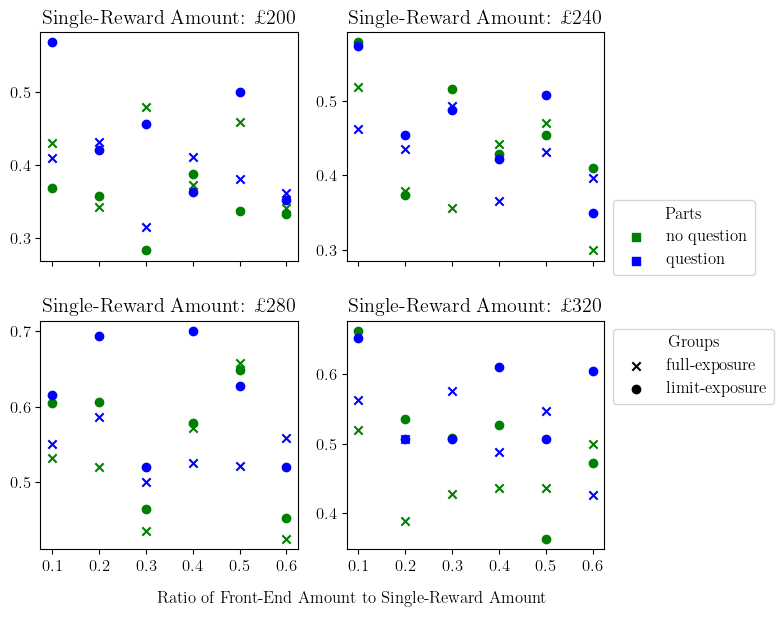

In [24]:
single_amounts = tab['single_amount'].unique()
front_ratios = tab['front_ratio'].unique()
groups = tab['group'].unique()
parts = tab['part'].unique()
colors = ['green','blue']
markers = ['x','o']

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
idx_matrix = single_amounts.reshape(2, 2)

for idx, single_amount in enumerate(single_amounts):
    row_idx, col_idx = np.where(idx_matrix == single_amount)
    ax = axes[row_idx[0], col_idx[0]]  # Access the correct subplot using row and column indices
    for g in range(len(groups)):
        for p in range(len(parts)):
            subset = tab[(tab['single_amount'] == single_amount) & 
                        (tab['part'] == parts[p]) &
                        (tab['group'] == groups[g])]        
            ax.scatter(subset['front_ratio'], subset['choice_value'], color=colors[p], marker=markers[g])
    
    ax.set_xticks(front_ratios)
    ax.set_title(f'Single-Reward Amount: £{single_amount}')

    if ax == axes[0,1]:
        ax.scatter([], [], color=colors[0], marker='s')
        ax.scatter([], [], color=colors[1], marker='s')

        ax.legend(ax.collections[-2:], parts, title='Parts',
                        loc='upper left', bbox_to_anchor=(1, 0.3))
    
    if ax == axes[1,1]:
        ax.scatter([], [], color='black', marker=markers[0])
        ax.scatter([], [], color='black', marker=markers[1])

        ax.legend(ax.collections[-2:], groups, title='Groups',
                        loc='upper left', bbox_to_anchor=(1, 1))
        

# Set common x-axis label
fig.text(0.45, -0.02, 'Ratio of Front-End Amount to Single-Reward Amount', ha='center')
plt.tight_layout()
plt.show()

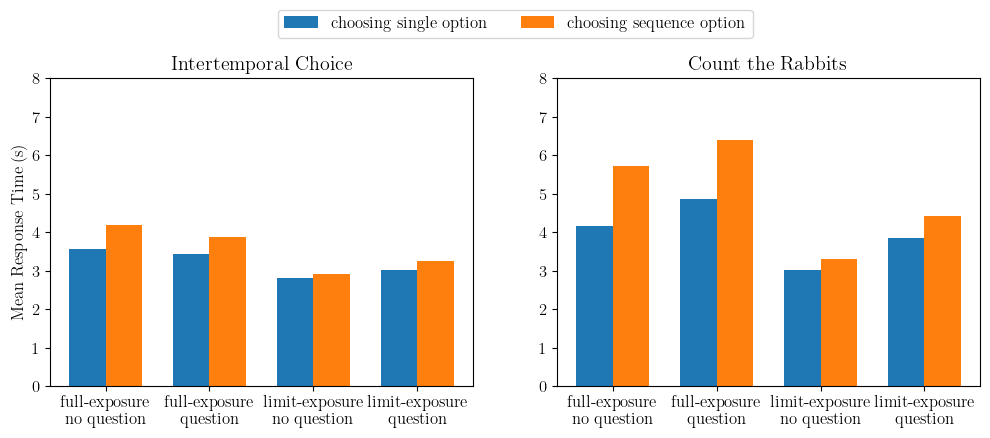

In [53]:
outlier_threshold = 0.995
df_total_time = df_total[df_total['response_time'] < df_total['response_time'].quantile(outlier_threshold)]
df_rabbit_time = df_rabbit[df_rabbit['response_time'] < df_rabbit['response_time'].quantile(outlier_threshold)]

tab_time_choice = df_total_time.groupby(['group','part','choice_value'])['response_time'].mean().reset_index()
tab_time_choice['group_part'] = tab_time_choice.apply(lambda x:  x['group'] + '\n' + x['part'],axis=1)
tab_time_rabbit = df_rabbit_time.groupby(['group','part','choice_value'])['response_time'].mean().reset_index()
tab_time_rabbit['group_part'] = tab_time_rabbit.apply(lambda x:  x['group'] + '\n' + x['part'],axis=1)

choice_label = ['choosing single option', 'choosing sequence option']
group_parts = tab_time_choice['group_part'].unique()
choice_values = tab_time_choice['choice_value'].unique()
index = range(len(group_parts))
bar_width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for i, choice_value in enumerate(choice_values):
    choice_value_data = tab_time_choice[tab_time_choice['choice_value'] == choice_value]
    axes[0].bar([x + i * bar_width for x in index], choice_value_data['response_time']*0.001, bar_width, label=choice_label[i])
    axes[0].set_ylabel('Mean Response Time (s)')
    axes[0].set_title('Intertemporal Choice')
    axes[0].set_yticks(np.arange(9))

    choice_value_data = tab_time_rabbit[tab_time_rabbit['choice_value'] == choice_value]
    axes[1].bar([x + i * bar_width for x in index], choice_value_data['response_time']*0.001, bar_width, label=choice_label[i])
    axes[1].set_title('Count the Rabbits')
    axes[1].legend(bbox_to_anchor=(-0.1, 1.25), loc='upper center',ncol=2)
    axes[1].set_yticks(np.arange(9))


plt.xticks([x + bar_width / 2 for x in index], group_parts)
plt.savefig('figures/response_time.png')
plt.show()

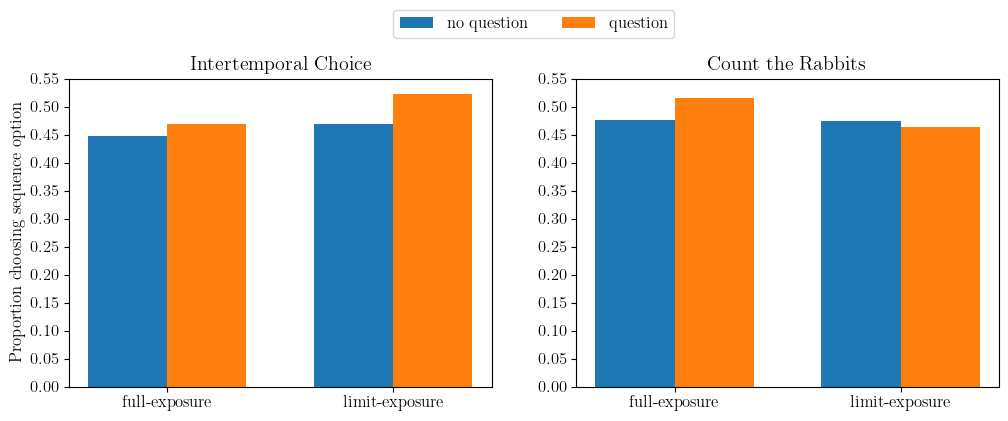

In [29]:
tab_choice = df_total.groupby(['group','part'])['choice_value'].mean().reset_index()
tab_rabbit = df_rabbit.groupby(['group','part'])['choice_value'].mean().reset_index()

parts = tab_choice['part'].unique()
groups = tab_choice['group'].unique()
index = range(len(groups))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for i, p in enumerate(parts):
    task_data = tab_choice[tab_choice['part'] == p]
    axes[0].bar([x + i * bar_width for x in index], task_data['choice_value'], bar_width, label=parts[i])
    axes[0].set_ylabel('Proportion choosing sequence option')
    axes[0].set_yticks(np.arange(12)*0.05)
    axes[0].set_title('Intertemporal Choice')

    task_data = tab_rabbit[tab_rabbit['part'] == p]
    axes[1].bar([x + i * bar_width for x in index], task_data['choice_value'], bar_width, label=parts[i])
    # axes[1].set_ylabel('Proportion choosing sequence option')
    axes[1].set_yticks(np.arange(12)*0.05)
    axes[1].set_title('Count the Rabbits')
    axes[1].legend(bbox_to_anchor=(-0.1, 1.25), loc='upper center',ncol=2)
    
plt.xticks([x + bar_width / 2 for x in index], groups)
plt.show()

Number of people choosing wrong rabbits: 68


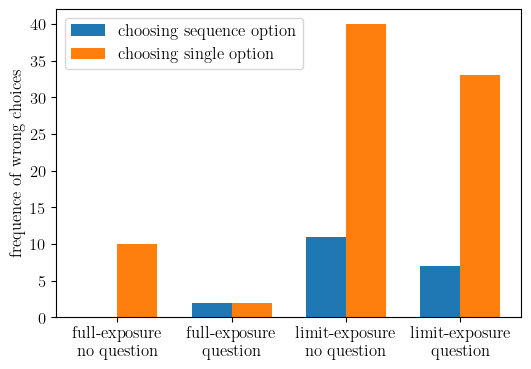

In [52]:
wrong_workers = df_rabbit['worker_id'][df_rabbit['choice_correct'] == 0].unique()
print('Number of people choosing wrong rabbits:',len(wrong_workers))

wrong_rabbit = df_rabbit[df_rabbit['choice_correct'] == 0].groupby(['group','part','diff_amount'])['choice_correct'].count().reset_index()
wrong_rabbit.loc[len(wrong_rabbit)] = ['full-exposure','no question',-1,0]
wrong_rabbit['group_part'] = wrong_rabbit.apply(lambda x:  x['group'] + '\n' + x['part'],axis=1)
wrong_rabbit['diff_amount'] = wrong_rabbit['diff_amount'].replace({1: 'choosing single option', -1: 'choosing sequence option'})
wrong_rabbit = wrong_rabbit.sort_values(['group_part','diff_amount'])

diff_rabbit = wrong_rabbit['diff_amount'].unique()
group_parts = wrong_rabbit['group_part'].unique()
index = range(len(group_parts))
bar_width = 0.35

plt.figure(figsize=(6,4))

for i, diff in enumerate(diff_rabbit):
    _data = wrong_rabbit[wrong_rabbit['diff_amount'] == diff]
    plt.bar([x + i * bar_width for x in index], _data['choice_correct'], bar_width, label=diff_rabbit[i])

plt.ylabel('frequence of wrong choices')
plt.legend()
plt.xticks([x + bar_width / 2 for x in index], group_parts)
plt.show()

In [ ]:
df_total.to_csv(out_path_choice)
df_rabbit.to_csv(out_path_rabbit)

In [2]:
df_total = pd.read_csv('choice_data.csv',sep=',',index_col=0)
df_rabbit = pd.read_csv('rabbit_data.csv',sep=',',index_col=0)

sum_choice_seq = df_total.groupby('worker_id')['choice_value'].sum().to_frame()
analysis_workers = sum_choice_seq[(sum_choice_seq['choice_value'] != 24) & (sum_choice_seq['choice_value'] != 0)].index
df_analysis = df_total[df_total['worker_id'].isin(analysis_workers)]

In [16]:
df_total.groupby(['group','part'])['choice_value'].mean()

group           part       
full-exposure   no question    0.448198
                question       0.469032
limit-exposure  no question    0.468037
                question       0.522831
Name: choice_value, dtype: float64

In [9]:
0.469032 - 0.448198

0.02083400000000002

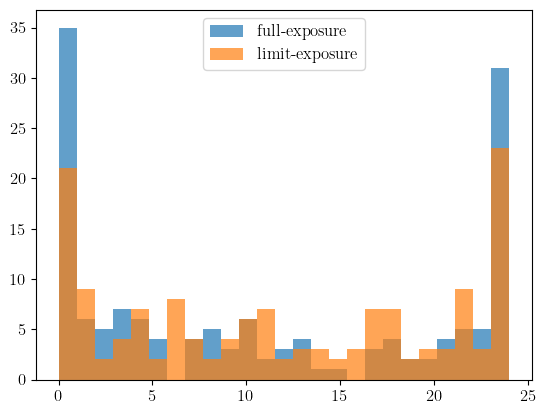

In [6]:
plt.hist(df_total[(df_total['group_value']==0)].groupby(['worker_id'])['choice_value'].sum(),bins=25,label='full-exposure',alpha=0.7)
plt.hist(df_total[(df_total['group_value']==1)].groupby(['worker_id'])['choice_value'].sum(),bins=25,label='limit-exposure',alpha=0.7)
plt.legend()

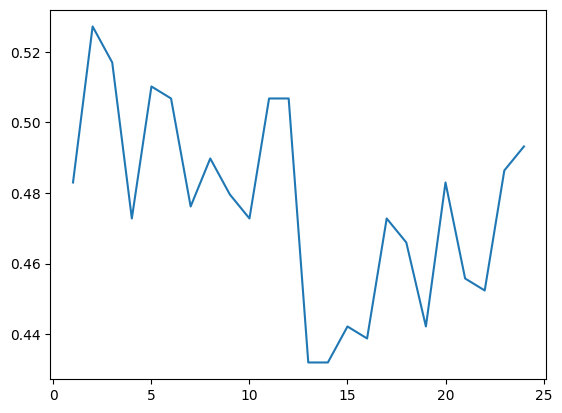

In [42]:
df_total['q_rank'] = df_total.groupby('worker_id').cumcount() + 1
rank_sum = df_total.groupby(['q_rank'])['choice_value'].mean()
plt.plot(rank_sum.index,rank_sum)

In [4]:
mod = smf.logit('choice_value ~ group_value + I((group_value==0)*part_value) + I((group_value==1)*part_value) + C(single_amount) + C(front_ratio)', data=df_analysis)
result = mod.fit(cov_type='cluster',cov_kwds={'groups':df_analysis['worker_id']})
# result = mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.661439
         Iterations 5


d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           choice_value   No. Observations:                 4416
Model:                          Logit   Df Residuals:                     4404
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Sep 2024   Pseudo R-squ.:                 0.04301
Time:                        00:28:54   Log-Likelihood:                -2920.9
converged:                       True   LL-Null:                       -3052.2
Covariance Type:              cluster   LLR p-value:                 6.609e-50
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -0.4202      0.174     -2.418      0.016      -0.761      -0.080
group_value[T.True]                            0.0534      0.200      0.267      0.789      -0.338       0.445
I((group_value == 0) * part_value)[T.True]     0.1599      0.108      1.482      0.138      -0.052       0.371
I((group_value == 1) * part_value)[T.True]     0.3403      0.099      3.454      0.001       0.147       0.533
C(single_amount)[T.240]                        0.3200      0.073      4.412      0.000       0.178       0.462
C(single_amount)[T.280]                        1.0936      0.084     13.032      0.000       0.929       1.258
C(single_amount)[T.320]                        0.7813      0.081      9.612      0.000       0.622       0.941
C(front_ratio)[T.0.2]                         -0.4550      0.082     -5.517      0.000      -0.617      -0.293
C(front_ratio)[T.0.3]                         -0.5573      0.095     -5.846      0.000      -0.744      -0.370
C(front_ratio)[T.0.4]                         -0.4198      0.100     -4.208      0.000      -0.615      -0.224
C(front_ratio)[T.0.5]                         -0.3198      0.117     -2.735      0.006      -0.549      -0.091
C(front_ratio)[T.0.6]                         -0.7790      0.132     -5.912      0.000      -1.037      -0.521
==============================================================================================================
"""

In [19]:
mod = smf.logit('choice_value ~ group_value + I((group_value==0)*part_value) + I((group_value==1)*part_value) + C(single_amount) + C(front_ratio) + C(worker_id)', data=df_analysis)
result = mod.fit(cov_type='cluster',cov_kwds={'groups':df_analysis['worker_id']})
# result = mod.fit()
result.summary()

d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

Optimization terminated successfully.
         Current function value: 0.442363
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           choice_value   No. Observations:                 4416
Model:                          Logit   Df Residuals:                     4222
Method:                           MLE   Df Model:                          193
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                  0.3600
Time:                        05:00:55   Log-Likelihood:                -1953.5
converged:                       True   LL-Null:                       -3052.2
Covariance Type:              cluster   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -0.6299      0.196     -3.212      0.001      -1.014      -0.245
group_value[T.True]                           -0.0524      0.296     -0.177      0.859      -0.632       0.527
I((group_value == 0) * part_value)[T.True]     0.2890      0.185      1.566      0.117      -0.073       0.651
I((group_value == 1) * part_value)[T.True]     0.5347      0.162      3.299      0.001       0.217       0.852
C(single_amount)[T.240]                        0.5304      0.119      4.457      0.000       0.297       0.764
C(single_amount)[T.280]                        1.7953      0.126     14.244      0.000       1.548       2.042
C(single_amount)[T.320]                        1.2932      0.124     10.411      0.000       1.050       1.537
C(front_ratio)[T.0.2]                         -0.7557      0.135     -5.616      0.000      -1.019      -0.492
C(front_ratio)[T.0.3]                         -0.9153      0.156     -5.865      0.000      -1.221      -0.609
C(front_ratio)[T.0.4]                         -0.6883      0.166     -4.150      0.000      -1.013      -0.363
C(front_ratio)[T.0.5]                         -0.5165      0.194     -2.661      0.008      -0.897      -0.136
C(front_ratio)[T.0.6]                         -1.2810      0.220     -5.826      0.000      -1.712      -0.850
C(worker_id)[T.481489]                         1.4985      0.034     44.375      0.000       1.432       1.565
C(worker_id)[T.481491]                         2.7953      0.031     90.300      0.000       2.735       2.856
C(worker_id)[T.481493]                        -3.1610      0.028   -113.128      0.000      -3.216      -3.106
C(worker_id)[T.481501]                         0.2069      0.007     29.352      0.000       0.193       0.221
C(worker_id)[T.481502]                        -1.9023      0.317     -6.008      0.000      -2.523      -1.282
C(worker_id)[T.481503]                         2.9209      0.329      8.868      0.000       2.275       3.567
C(worker_id)[T.481504]                        -1.9141      0.321     -5.957      0.000      -2.544      -1.284
C(worker_id)[T.481505]                        -0.5132      0.318     -1.615      0.106      -1.136       0.110
C(worker_id)[T.481509]                         3.6646      0.335     10.936      0.000       3.008       4.321
C(worker_id)[T.481511]                        -1.2387      0.317     -3.904      0.000      -1.861      -0.617
C(worker_id)[T.481512]                        -1.5231      0.312     -4.885      0.000      -2.134      -0.912
C(worker_id)[T.481516]                         1.4814      0.029     50.503      0.000       1.424       1.539
C(worker_id)[T.481517]                        -0.1864      0.004    -41.522      0.000      -0.195      -0.178
C(worker_id)[T.481522]                         2.4043      0.041     58.377      0.000       2.324       2.485
C(worker_id)[T.481523]

In [47]:
mod = smf.logit('choice_value ~ group_value + I((group_value==0)*part_value) + I((group_value==1)*part_value) + C(front_amount) + C(single_amount) + C(diff_amount)', data=df_rabbit)
result = mod.fit(cov_type='cluster',cov_kwds = {'groups':df_rabbit['worker_id']})
result.summary()

Optimization terminated successfully.
         Current function value: 0.123110
         Iterations 9


d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           choice_value   No. Observations:                 3504
Model:                          Logit   Df Residuals:                     3496
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                  0.8222
Time:                        05:23:08   Log-Likelihood:                -431.38
converged:                       True   LL-Null:                       -2426.5
Covariance Type:              cluster   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -4.3312      0.309    -14.026      0.000      -4.936      -3.726
group_value[T.True]                           -0.7296      0.330     -2.208      0.027      -1.377      -0.082
I((group_value == 0) * part_value)[T.True]     0.5738      0.226      2.539      0.011       0.131       1.017
I((group_value == 1) * part_value)[T.True]     0.0624      0.318      0.196      0.844      -0.561       0.686
C(front_amount)[T.2]                           0.1060      0.274      0.387      0.699      -0.431       0.643
C(front_amount)[T.3]                          -0.6546      0.228     -2.876      0.004      -1.101      -0.209
C(single_amount)[T.8]                          0.1451      0.166      0.876      0.381      -0.180       0.470
C(diff_amount)[T.1]                            7.7970      0.377     20.681      0.000       7.058       8.536
==============================================================================================================
"""

In [48]:
mod = smf.logit('choice_value ~ group_value + I((group_value==0)*part_value) + I((group_value==1)*part_value) + C(front_amount) + C(single_amount) + C(diff_amount) + C(worker_id)', data=df_rabbit)
result = mod.fit(cov_type='cluster',cov_kwds = {'groups':df_rabbit['worker_id']})
result.summary()

d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

         Current function value: 0.071438
         Iterations: 35


d:\Python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           choice_value   No. Observations:                 3504
Model:                          Logit   Df Residuals:                     3204
Method:                           MLE   Df Model:                          299
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                  0.8968
Time:                        05:23:47   Log-Likelihood:                -250.32
converged:                      False   LL-Null:                       -2426.5
Covariance Type:              cluster   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -6.5474      0.260    -25.194      0.000      -7.057      -6.038
group_value[T.True]                           -4.3790      1.355     -3.232      0.001      -7.035      -1.723
I((group_value == 0) * part_value)[T.True]     1.3783      0.600      2.297      0.022       0.202       2.554
I((group_value == 1) * part_value)[T.True]     0.1516      0.368      0.412      0.681      -0.570       0.873
C(front_amount)[T.2]                           0.1832      0.378      0.484      0.628      -0.558       0.924
C(front_amount)[T.3]                          -0.9501      0.338     -2.807      0.005      -1.614      -0.287
C(single_amount)[T.8]                          0.1921      0.241      0.796      0.426      -0.281       0.665
C(diff_amount)[T.1]                           11.7104      1.091     10.729      0.000       9.571      13.850
C(worker_id)[T.481485]                         5.1715      0.554      9.333      0.000       4.085       6.258
C(worker_id)[T.481487]                         1.0499      0.218      4.814      0.000       0.622       1.477
C(worker_id)[T.481489]                         5.1721      0.555      9.318      0.000       4.084       6.260
C(worker_id)[T.481491]                         0.9986      0.097     10.291      0.000       0.808       1.189
C(worker_id)[T.481493]                         1.0368      0.189      5.487      0.000       0.666       1.407
C(worker_id)[T.481497]                         5.1700      0.553      9.346      0.000       4.086       6.254
C(worker_id)[T.481501]                         5.1726      0.554      9.330      0.000       4.086       6.259
C(worker_id)[T.481502]                        -0.0161      1.076     -0.015      0.988      -2.126       2.093
C(worker_id)[T.481503]                        -4.2002      1.550     -2.711      0.007      -7.237      -1.163
C(worker_id)[T.481504]                         0.1300      1.022      0.127      0.899      -1.874       2.134
C(worker_id)[T.481505]                         0.1801      1.016      0.177      0.859      -1.811       2.172
C(worker_id)[T.481506]                         0.2940      0.967      0.304      0.761      -1.602       2.190
C(worker_id)[T.481508]                         0.2283      0.992      0.230      0.818      -1.717       2.173
C(worker_id)[T.481509]                         0.1332      1.026      0.130      0.897      -1.877       2.143
C(worker_id)[T.481510]                         0.2476      0.974      0.254      0.799      -1.662       2.157
C(worker_id)[T.481511]                         0.0895      1.037      0.086      0.931      -1.943       2.122
C(worker_id)[T.481512]                         0.2613      0.988      0.265      0.791      -1.675       2.197
C(worker_id)[T.481513]                         5.1730      0.555      9.325      0.000       4.086       6.260
C(worker_id)[T.481515]

In [62]:
wrong_rabbit = df_rabbit[df_rabbit['choice_correct'] == False]
print(wrong_rabbit.groupby(['group','part','preference'])['choice_value'].count())
print('Number of people who made wrong choices:',wrong_rabbit['worker_id'].unique().shape[0])

group           part         preference
full-exposure   no question  single        10
                question     sequence       2
                             single         2
limit-exposure  no question  sequence      11
                             single        40
                question     sequence       7
                             single        33
Name: choice_value, dtype: int64
Number of people who made wrong choices: 68


In [54]:
expected_power = 0.8
expected_n_question = 24
effect_size = 0.2704
se = 0.162
sample_size = 187 * 24
sig_level = 0.05

sigma = (se * np.sqrt(sample_size))

power = stats.norm.cdf(-stats.norm.ppf(1-sig_level/2) + effect_size/se)
expected_sample = ((stats.norm.ppf(1-sig_level/2) + stats.norm.ppf(expected_power))*sigma/effect_size)**2
print('power:',power)
print('sample size needed:',expected_sample / expected_n_question)

power: 0.38559136516737247
sample size needed: 526.8244660677495


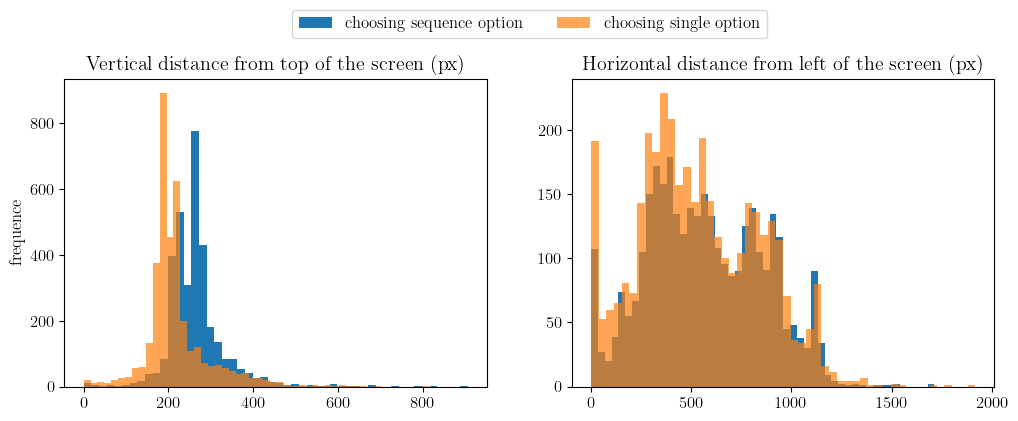

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_total['mouseY'][df_total['preference'] == 'sequence'],bins=50,label='choosing sequence option')
axes[0].hist(df_total['mouseY'][df_total['preference'] == 'single'],bins=50,label='choosing single option',alpha=0.7)
axes[0].set_title('Vertical distance from top of the screen (px)')
axes[0].set_ylabel('frequence')

axes[1].hist(df_total['mouseX'][df_total['preference'] == 'sequence'],bins=50,label='choosing sequence option')
axes[1].hist(df_total['mouseX'][df_total['preference'] == 'single'],bins=50,label='choosing single option',alpha=0.7)
axes[1].set_title('Horizontal distance from left of the screen (px)')
axes[1].legend(bbox_to_anchor=(-0.1, 1.25), loc='upper center',ncol=2)

plt.show()

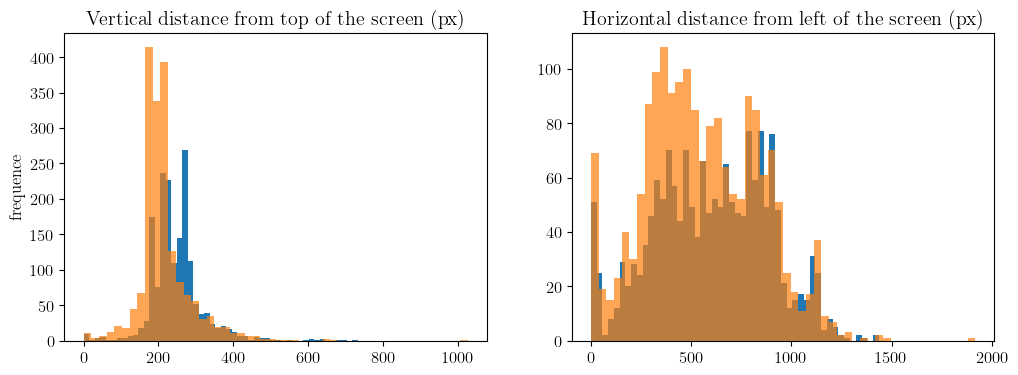

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_rabbit['mouseY'][df_rabbit['preference'] == 'sequence'],bins=50,label='choosing sequence option')
axes[0].hist(df_rabbit['mouseY'][df_rabbit['preference'] == 'single'],bins=50,label='choosing single option',alpha=0.7)
axes[0].set_title('Vertical distance from top of the screen (px)')
axes[0].set_ylabel('frequence')

axes[1].hist(df_rabbit['mouseX'][df_rabbit['preference'] == 'sequence'],bins=50,label='choosing sequence option')
axes[1].hist(df_rabbit['mouseX'][df_rabbit['preference'] == 'single'],bins=50,label='choosing single option',alpha=0.7)
axes[1].set_title('Horizontal distance from left of the screen (px)')
# axes[1].legend(bbox_to_anchor=(-0.1, 1.25), loc='upper center',ncol=2)

plt.savefig('figures/mouse_rabbit.png')
plt.show()